# Construcción y transformación de datos
### Miembros del equipo 
- Ania María Díaz González Peyrot
- Paula Simonetta Madrid Pérez
- Omar Alejandro Quinn Toledo

In [42]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
datos = pd.read_csv("listingsbarcelonacsv.csv")

# Resumen de la Tercera Entrega: Selección y Limpieza de Datos

En la tercera entrega se enfocó en organizar y limpiar los datos de listings de Airbnb para garantizar que la información fuera relevante y manejable para los análisis posteriores. 
Se realizaron tres etapas principales
1. filtrado de datos
2. tratamiento de valores nulos
3. manejo de valores atípicos.

Durante el filtrado, se eliminaron columnas irrelevantes y se seleccionaron registros según criterios de negocio, como hosts más activos, propiedades con un número limitado de camas, superhosts y tipos de habitaciones predominantes, para lograr reducir los errores del dataset y mantener únicamente la información estratégica y funcional. En el tratamiento de valores nulos, se identificaron columnas con datos faltantes y se aplicaron estrategias de imputación o eliminación de registros con demasiados nulos. En la etapa de los valores atípicos, en las columnas cuantitativas se utilizaron diagramas de caja y reglas estadísticas, los valores extremos se corrigieron con eliminación o con la mediana, y las columnas cualitativas con nulos se rellenaron con "Desconocido" o otro str. 
Finalmente, los diferentes datasets filtrados y limpios se integraron mediante concatenación y enlaces entre columnas comunes, obteniendo un dataset confiable.


## Descripcion de columnas
Se separan en cualitativas y cuantitativas

- Atributos cuantitativos: cuáles son discretas, continuas y el comportamiento que tienen mediante histogramas (normal, sesgado). Especifica cuáles de estos atributos tienen valores atípicos
- Atributos cualitativos: Cuáles son ordinales y cuáles nominales, obtener el conteo por categoría de los datos.

In [43]:
### Necesitamos estandarizar tipos antes de separar columnas 
### Los tipos que se estandarizaran seran: fechas, booleanos, numericos y porcentajes
columnas_fechas   = ["last_scraped_date", "host_since_date", "first_review_date", "last_review_date", "calendar_last_scraped_date"]
columnas_dinero  = ["price_usd", "estimated_revenue_365d_usd"]
columnas_porcentaje = ["host_response_rate_ratio", "host_acceptance_rate_ratio"]
columnas_booleanos   = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"] 
### Aqui creamos listas con los nombres de las columnas que vamos a estandarizar para posteriormente con un ciclo for ir analizando dato por dato 
### y respectivamente ir estandarizando

In [44]:
# Columna de fechas a datetime
for c in columnas_fechas:
    if c in datos:
        datos[c] = pd.to_datetime(datos[c], errors="coerce", utc=True)

In [45]:
#Columna de dinero a numerico, regex para limpiar simbolos
for c in columnas_dinero:
    if c in datos:
        datos[c] = pd.to_numeric(datos[c].astype(str).str.replace(r"[^\d\.-]", "", regex=True), errors="coerce")

In [46]:
#Columna de porcetajes a numerico, rstrip para quitar el %
for c in columnas_porcentaje:
    if c in datos:
        datos[c] = pd.to_numeric(datos[c].astype(str).str.rstrip("%"),errors= "coerce") / 100.0

In [47]:
#Columna de booleanos, primero hice un diccionario con todos las formas posibles de escribir True o False, asegurando minusculas 
conversion = {"t": True, "f": False, "true": True, "false": False, "1": True, "0": False}
for c in columnas_booleanos:
    if c in datos:
        datos[c] = datos[c].astype(str).str.lower().map(conversion).astype("boolean")

In [48]:
#Comprobar que los datos sean del tipo que queremos
print(datos[columnas_dinero].dtypes)
print(datos[columnas_booleanos].dtypes)
print(datos[columnas_fechas].dtypes)
print(datos[columnas_porcentaje].dtypes)

KeyError: "None of [Index(['price_usd', 'estimated_revenue_365d_usd'], dtype='object')] are in the [columns]"

In [ ]:
### Separacion de columnas
excluir = {"Unnamed: 0", "id", "scrape_id", "host_id"} #esto es para evitar que ids se vayan a la lista de cualitativas

cols = [c for c in datos.columns if c not in excluir]
cuantitativas = datos[cols].select_dtypes(include=["number"]).columns.tolist()
cualitativas  = [c for c in cols if c not in cuantitativas]

print(f"Las columnas cualitativas son: {cualitativas}")
print(f"Las columnas cuantitativas son: {cuantitativas}")

Las columnas cualitativas son: ['listing_url', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 'instant_bookable']
Las columnas cuantitativas son: ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_av

Seleccion de discretas vs continuas 

Clasifiqué las variables numéricas como discretas cuando eran enteras (o integer-like) y presentaban baja cardinalidad (≤25 valores distintos o <5% de unicidad). Las demás se consideraron continuas.

In [ ]:
discretas = []
continuas = []

for c in cuantitativas:
    s = datos[c]
    nunique = s.nunique(dropna=False)
    denom = len(s) if len(s) else 1
    unique_ratio = nunique / denom

    is_int_dtype   = pd.api.types.is_integer_dtype(s)
    is_integer_like = is_int_dtype or s.fillna(0).mod(1).eq(0).all()

 
    if is_integer_like and (nunique <= 25 or unique_ratio < 0.05):
        discretas.append(c)
    else:
        continuas.append(c)

print(f"Las columnas discretas son: {discretas}")
print(f"Las columnas continuas son: {continuas}")

Las columnas discretas son: ['host_listings_count', 'host_total_listings_count', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
Las columnas continuas son: ['latitude', 'longitude', 'bathrooms', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_val

Para cada variable construí histogramas y revisé sus cuantiles (Q1, mediana y Q3). Si el tramo entre mediana y Q3 es parecido al tramo entre Q1 y mediana, la distribución es aproximadamente simétrica/normal.
Si el tramo mediana→Q3 es claramente mayor que Q1→mediana, interpreto sesgo a la derecha (cola hacia valores altos). Si ocurre al revés, sesgo a la izquierda.

Límite superior:
host_listings_count                             6.032996e+02
host_total_listings_count                       7.260716e+02
latitude                                        4.143440e+01
longitude                                       2.220400e+00
accommodates                                    1.020080e+01
bathrooms                                       3.968500e+00
bedrooms                                        5.891200e+00
beds                                            9.399500e+00
minimum_nights                                  1.054445e+02
maximum_nights                                  1.720753e+03
minimum_minimum_nights                          9.241180e+01
maximum_minimum_nights                          2.068142e+02
minimum_maximum_nights                          6.645825e+07
maximum_maximum_nights                          6.645831e+07
minimum_nights_avg_ntm                          1.627076e+02
maximum_nights_avg_ntm                          6.645123e+07
calenda

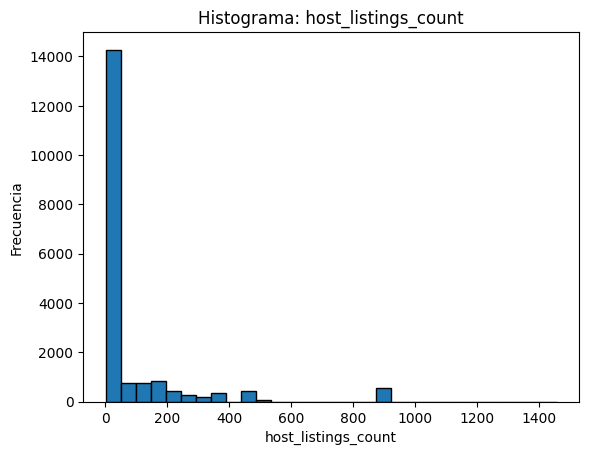

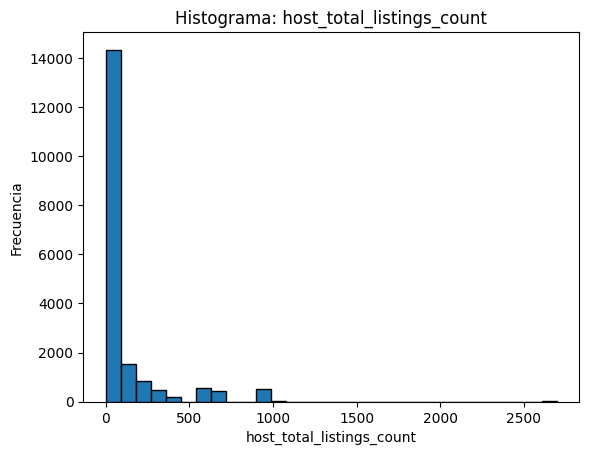

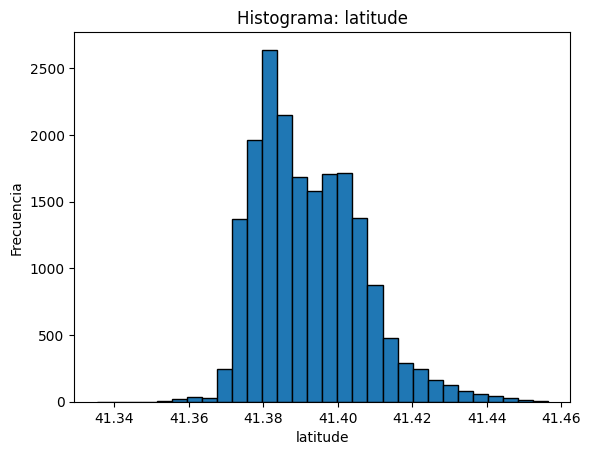

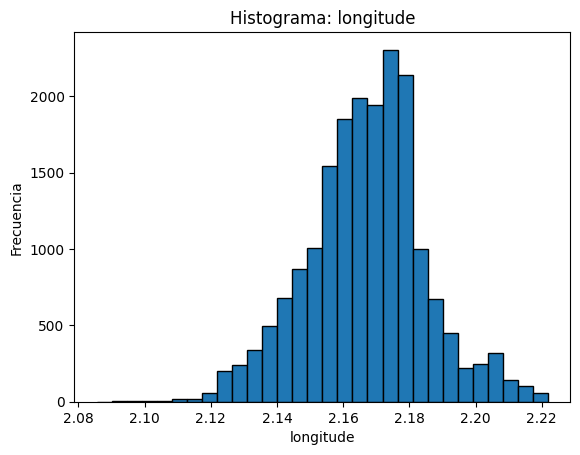

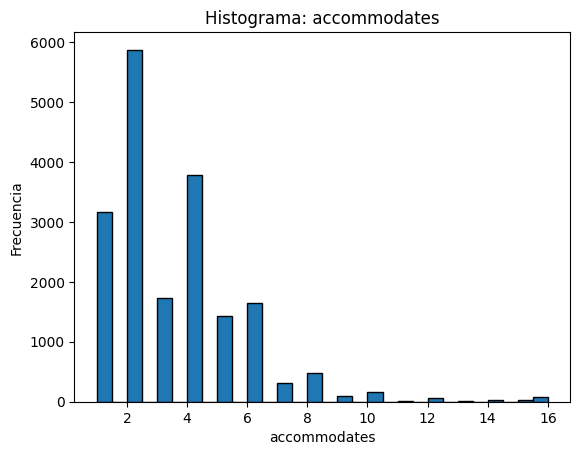

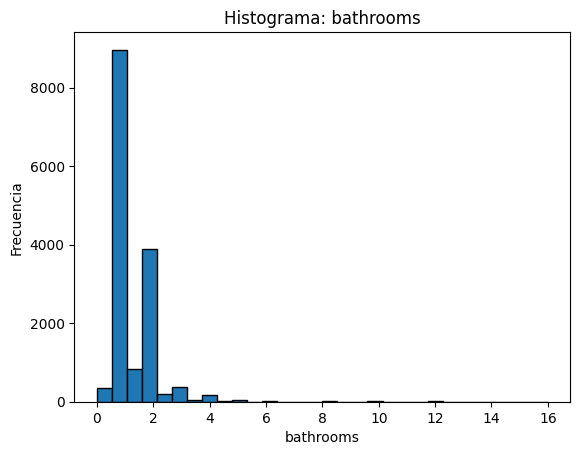

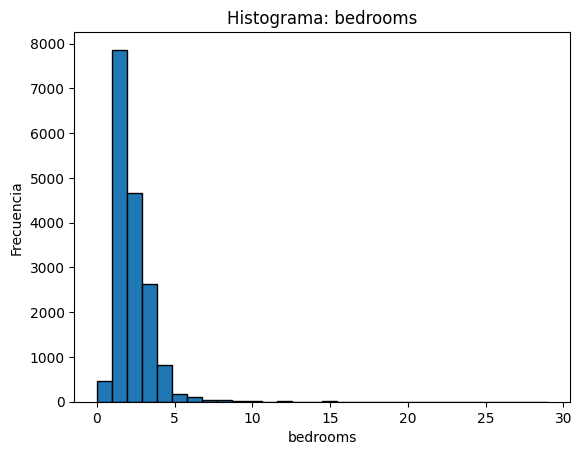

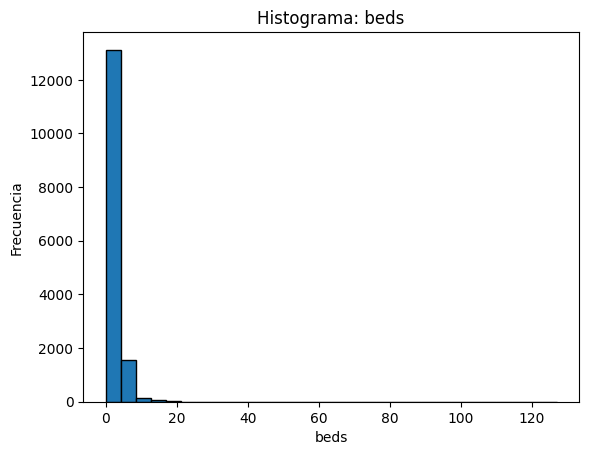

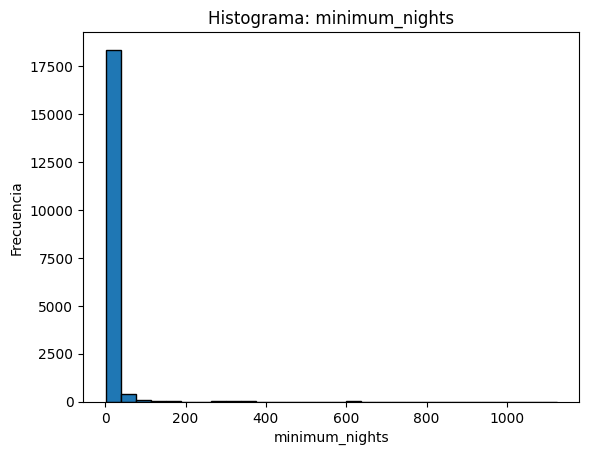

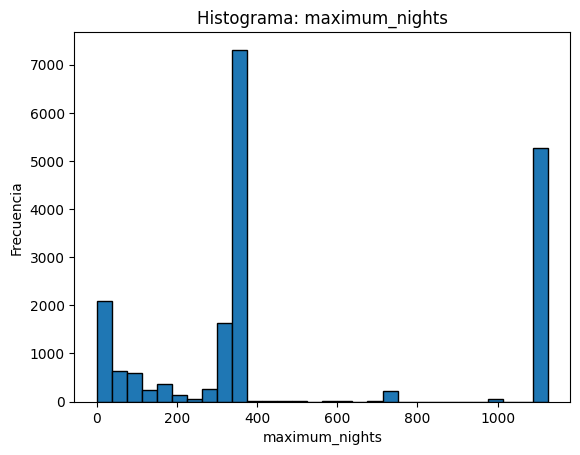

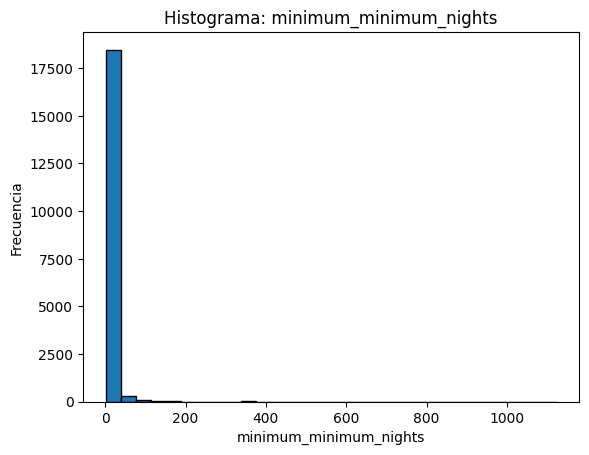

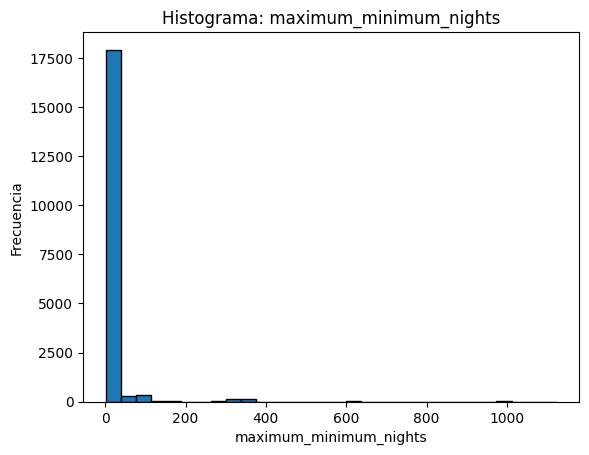

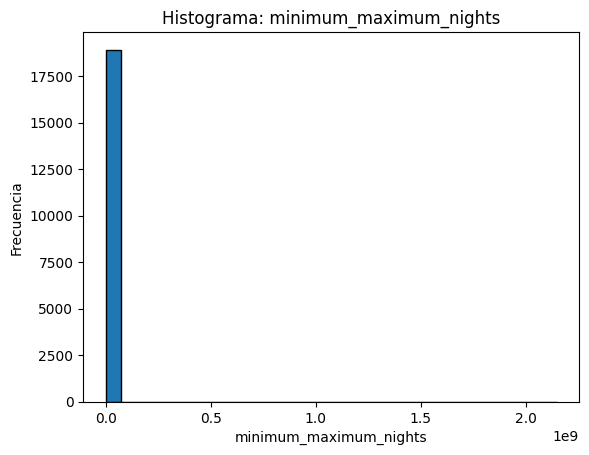

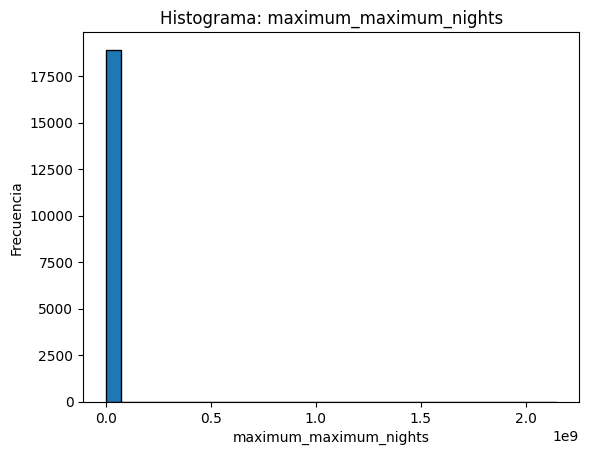

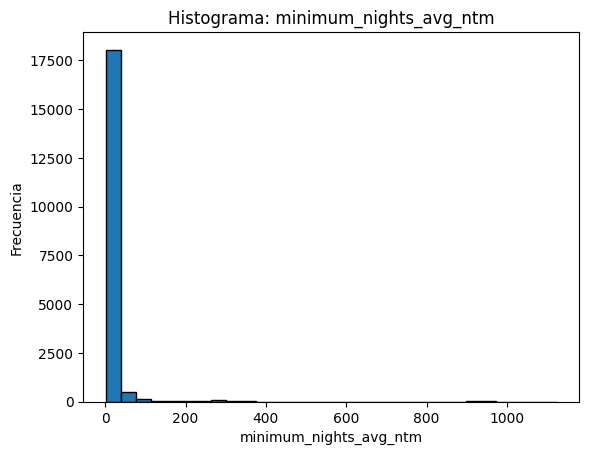

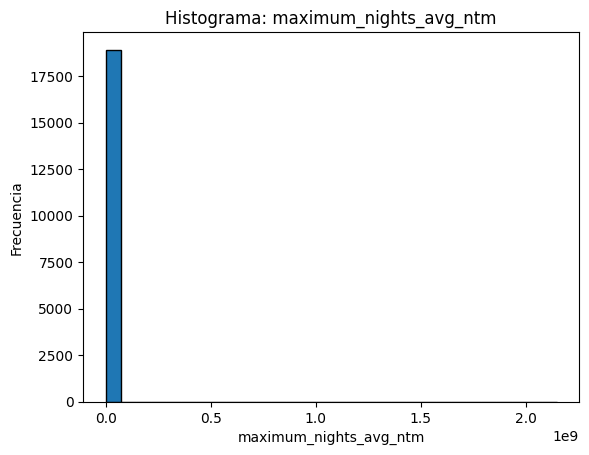

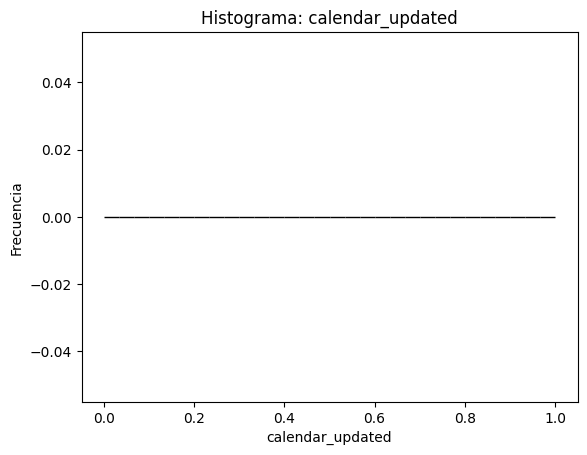

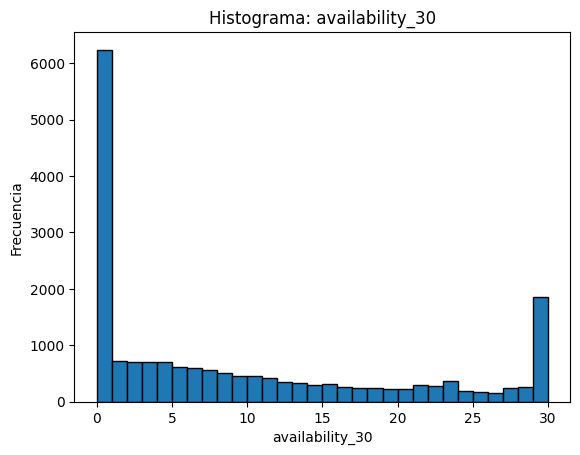

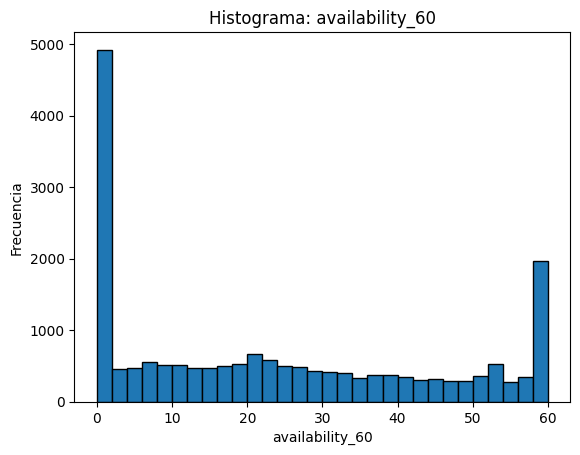

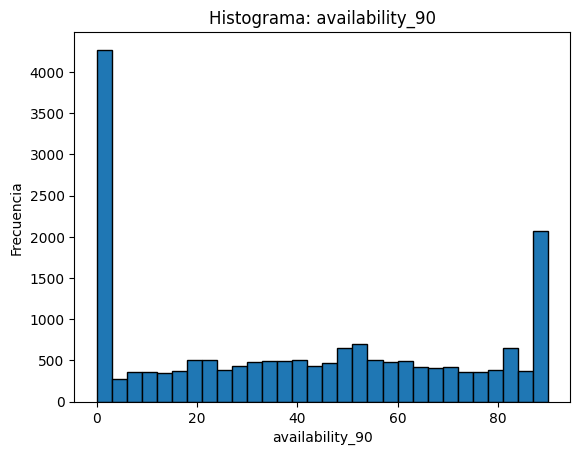

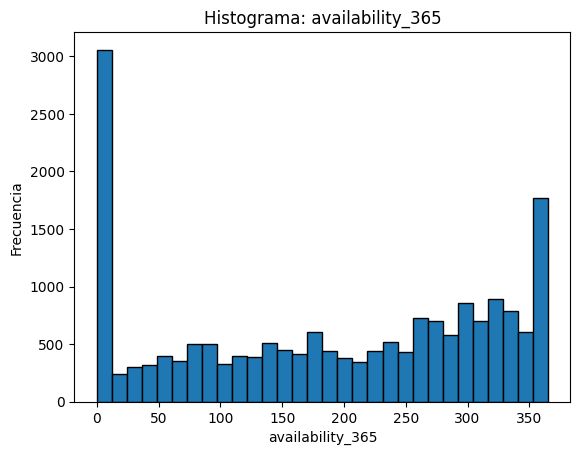

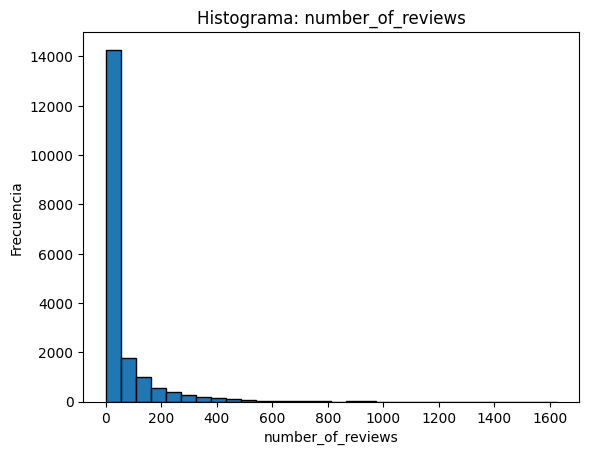

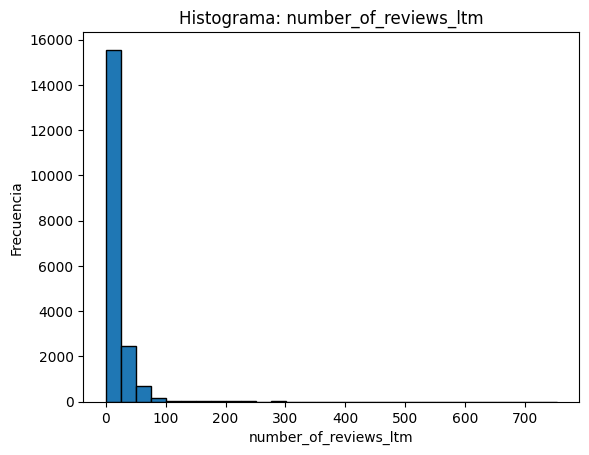

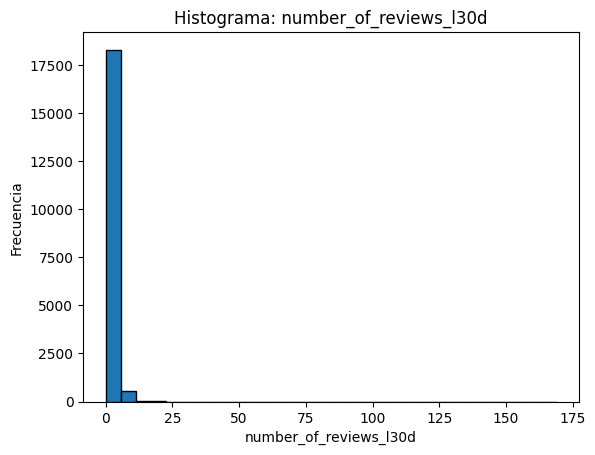

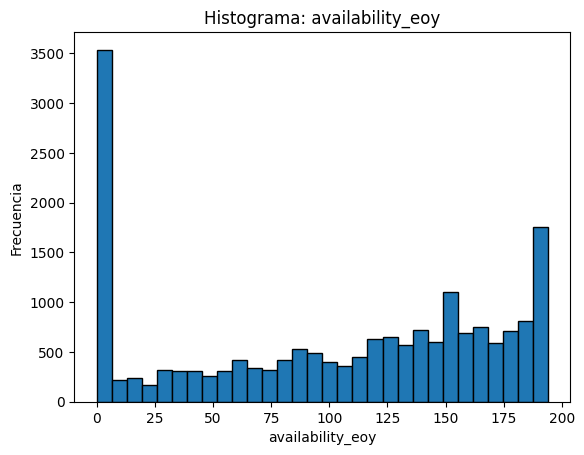

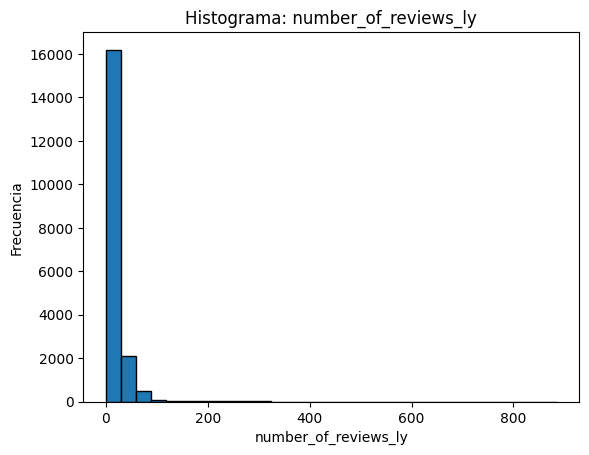

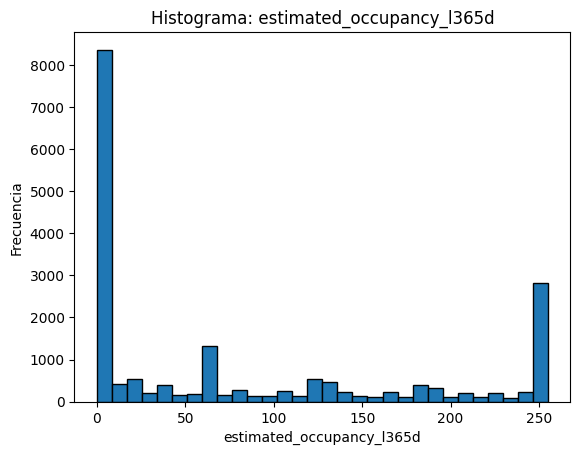

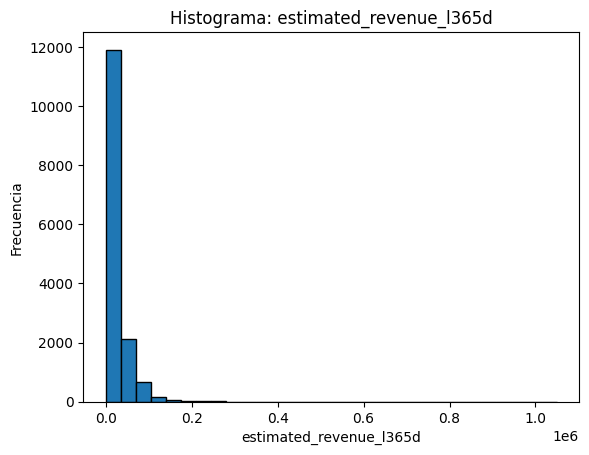

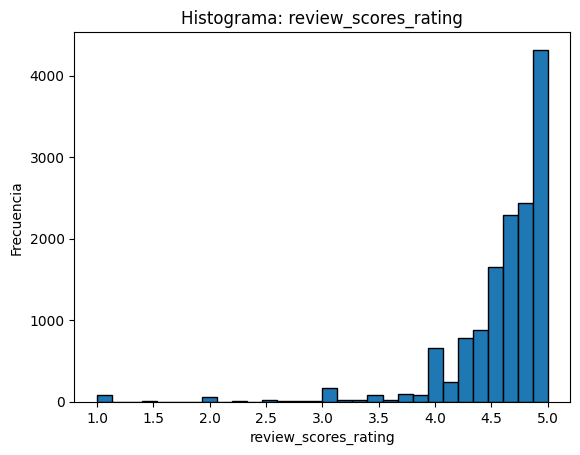

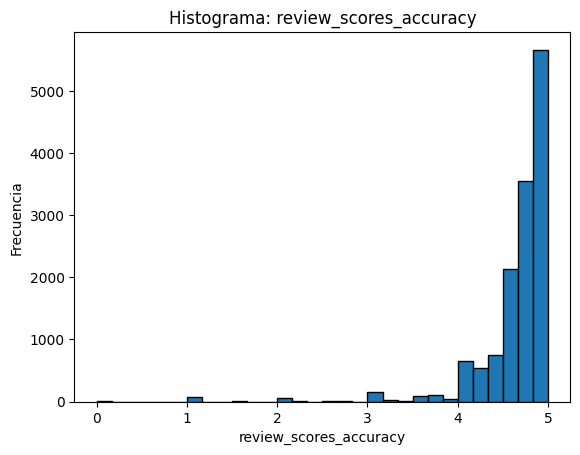

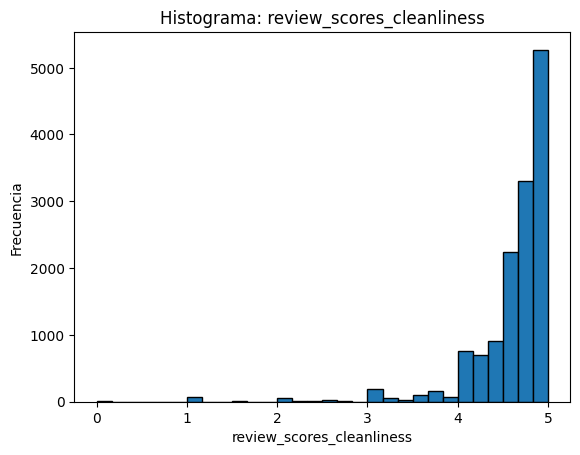

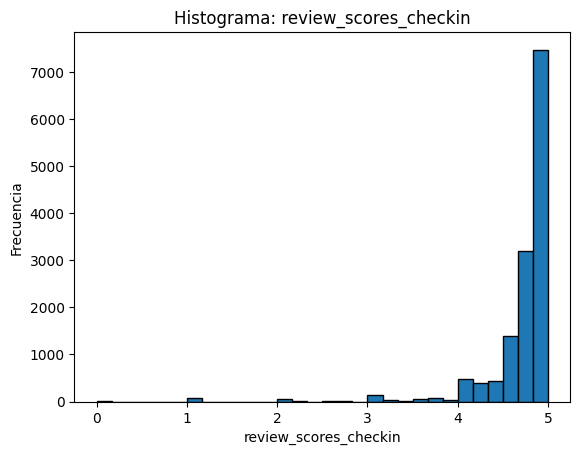

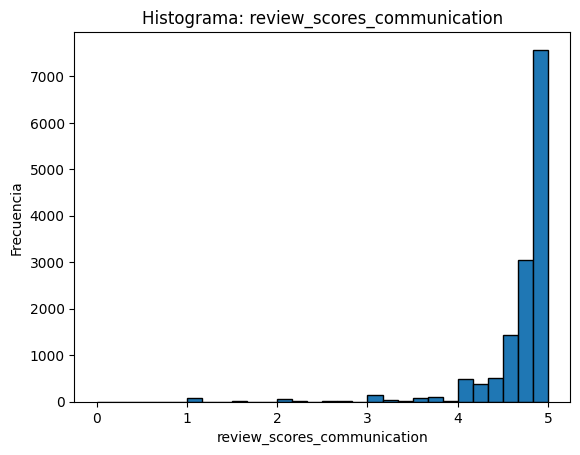

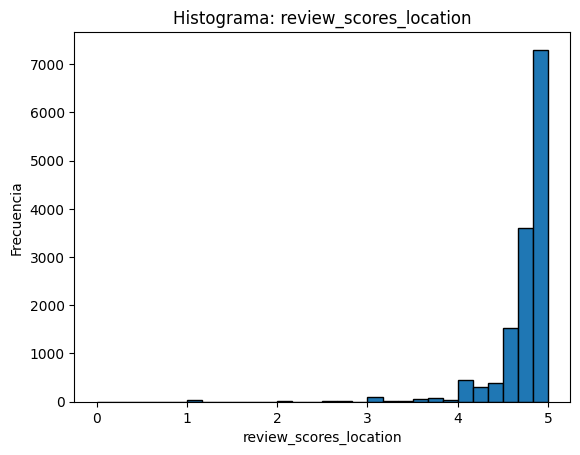

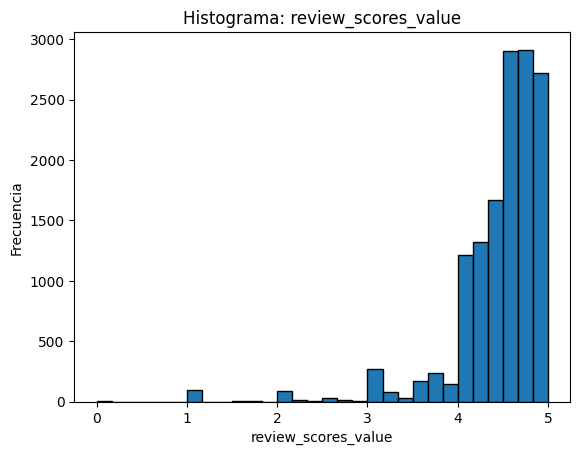

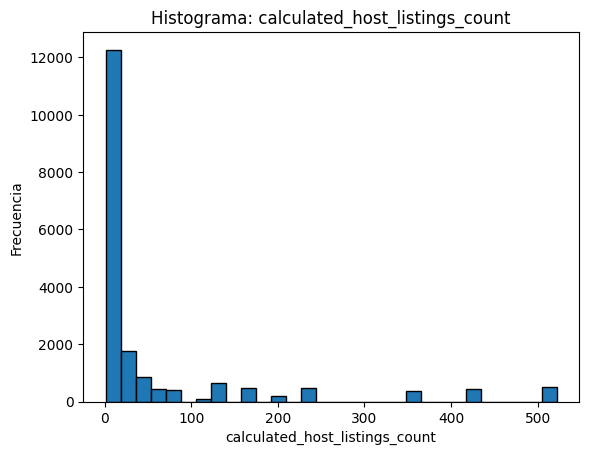

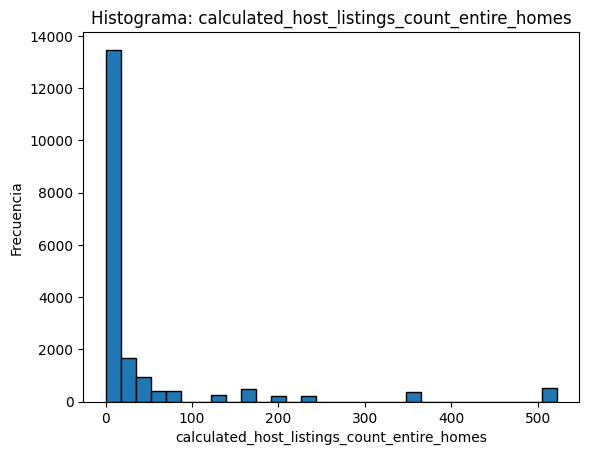

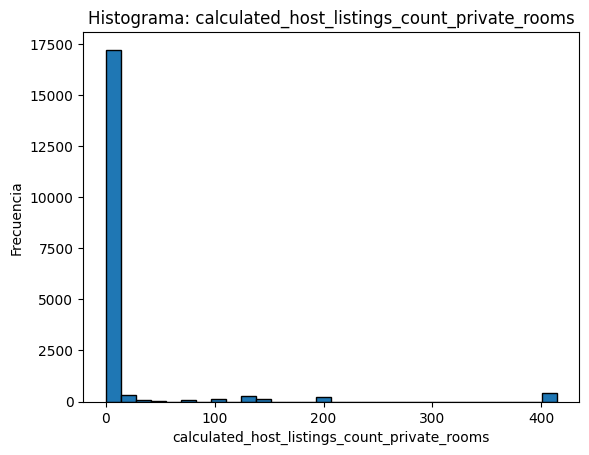

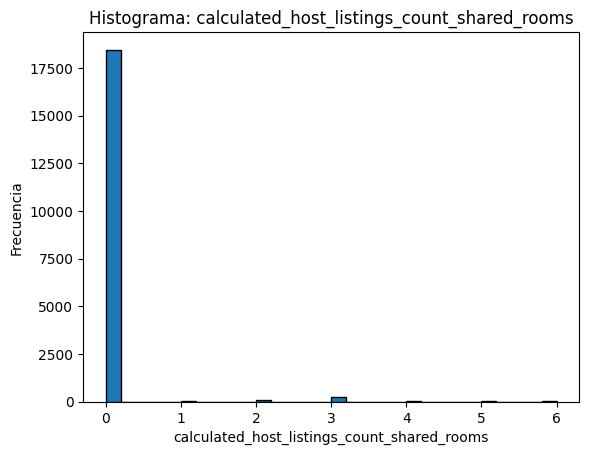

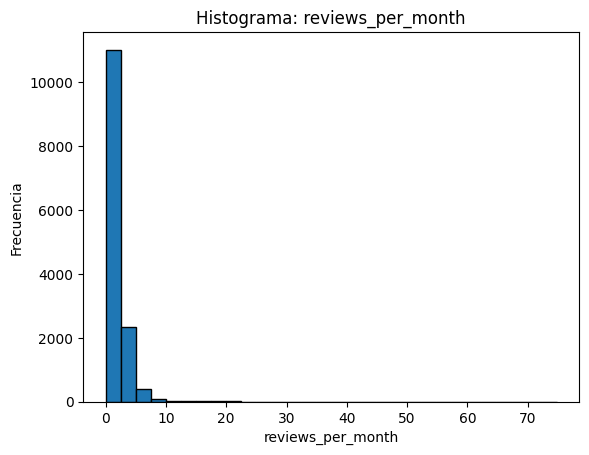

Con atípicos (IQR): host_listings_count, host_total_listings_count, latitude, longitude, accommodates, bathrooms, bedrooms, beds, minimum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, number_of_reviews_ly, estimated_revenue_l365d, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month
Sin atípicos (IQR): maximum_nights, calendar_updated, availability_30, availability_60, availability_90, availability_365, availability_eoy, estimated_occupancy_l365d


In [ ]:
# Outliers de cuantitativas 
y = datos[cuantitativas].select_dtypes(include="number")

Limite_Superior_std = y.mean() + 3*y.std()
Limite_Inferior_std = y.mean() - 3*y.std()

print("Límite superior:")
print(Limite_Superior_std.round(4))
print("\nLímite inferior:")
print(Limite_Inferior_std.round(4))
percentile25 = y.quantile(0.25)  # Q1
percentile75 = y.quantile(0.75)  # Q3
iqr = percentile75 - percentile25

Limite_Superior_iqr = percentile75 + 1.5*iqr
Limite_Inferior_iqr = percentile25 - 1.5*iqr

outlier_flags = {}     #alerta de outliers
for c in y.columns:
    s = y[c]
    li, ls = Limite_Inferior_iqr[c], Limite_Superior_iqr[c]
    outlier_flags[c] = bool(((s < li) | (s > ls)).any())

print("Límite superior (IQR):")
print(Limite_Superior_iqr.round(4))
print("\nLímite inferior (IQR):")
print(Limite_Inferior_iqr.round(4))

for c in datos[cuantitativas].columns:
    s = datos[cuantitativas][c]
    s.plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"Histograma: {c}")
    plt.xlabel(c); plt.ylabel("Frecuencia")
    plt.show()

con_outliers  = [c for c,v in outlier_flags.items() if v]
sin_outliers  = [c for c,v in outlier_flags.items() if not v]
print("Con atípicos (IQR):", ", ".join(con_outliers))
print("Sin atípicos (IQR):", ", ".join(sin_outliers))


La siguiente grafica barplot muestra qué tipos de habitación dominan en la ciudad. Normalmente los Entire home/apt concentran la mayoría de los anuncios, seguidos de Private room.

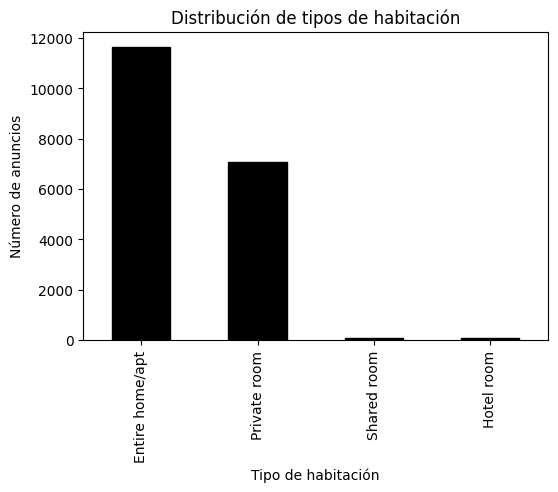

In [ ]:

plt.figure(figsize=(6,4))
datos["room_type"].value_counts().plot(kind="bar", color="black", edgecolor="black")
plt.title("Distribución de tipos de habitación")
plt.xlabel("Tipo de habitación")
plt.ylabel("Número de anuncios")
plt.show()


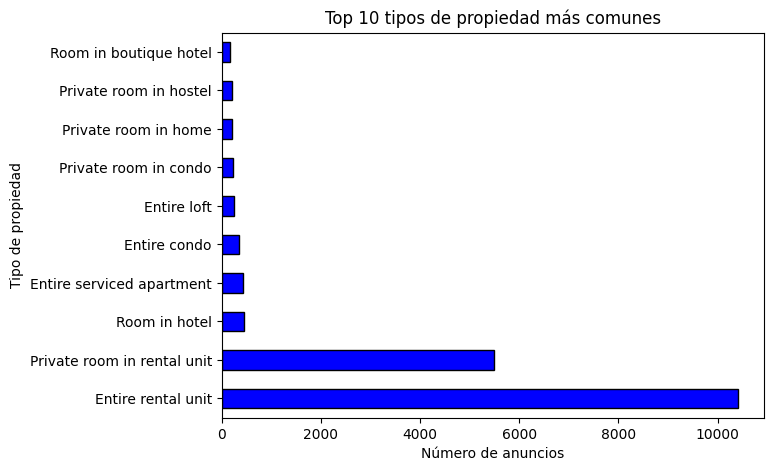

In [ ]:
#Aquí se destacan los tipos de propiedad más frecuentes, como los Apartments suelen ser mayoría, seguidos de Houses y otros tipos.
plt.figure(figsize=(7,5))
datos["property_type"].value_counts().head(10).plot(kind="barh", color="blue", edgecolor="black")
plt.title("Top 10 tipos de propiedad más comunes")
plt.xlabel("Número de anuncios")
plt.ylabel("Tipo de propiedad")
plt.show()


In [ ]:
Q1 = percentile25
Q3 = percentile75
Medianas = y.median()

forma = {}
for c in y.columns:
    q1, med, q3 = Q1[c], Medianas[c], Q3[c]
    left  = med - q1      # tramo Q1 -> Mediana
    right = q3 - med      # tramo Mediana -> Q3

    if left == 0 and right == 0:
        etiqueta = "simétrica (plana)"
    else:
        # evita divisiones por cero y clasifica por razón de tramos
        if left == 0 and right > 0:
            etiqueta = "sesgo a la derecha (fuerte)"
        elif right == 0 and left > 0:
            etiqueta = "sesgo a la izquierda (fuerte)"
        else:
            ratio = right / left
            if 0.8 <= ratio <= 1.2:
                etiqueta = "aprox. simétrica"
            elif ratio > 1.5:
                etiqueta = "sesgo a la derecha"
            elif ratio < (1/1.5):
                etiqueta = "sesgo a la izquierda"
            else:
                etiqueta = "leve asimetría"
    forma[c] = etiqueta

# === Resumen listo para tu reporte ===
con_outliers  = [c for c, v in outlier_flags.items() if v]
sin_outliers  = [c for c, v in outlier_flags.items() if not v]

print("Con atípicos (IQR):", ", ".join(con_outliers) if con_outliers else "ninguna")
print("Sin atípicos (IQR):", ", ".join(sin_outliers) if sin_outliers else "ninguna")

print("\nForma por cuantiles (Q1–Med–Q3):")
for c in y.columns:
    print(f"- {c}: {forma[c]}")

Declaré como ordinal host_response_time (mejor→peor respuesta) y el resto de cualitativas son nominales.

In [ ]:
ordinal_specs = {}
if "host_response_time" in cualitativas:
    orden_hr = ["within an hour","within a few hours","within a day","a few days or more"]
    presentes = [x for x in orden_hr if x in datos["host_response_time"].astype(str).unique().tolist()]
    if presentes:
        ordinal_specs["host_response_time"] = presentes
ordinales = list(ordinal_specs.keys())
nominales = [c for c in cualitativas if c not in ordinales]

print("ORDINALES:", ordinales)
print("NOMINALES", nominales)

## Tablas explicativas usando agrupamiento

En la siguiente tabla se muestra cuántos registros hay en cada tipo de habitación (Entire home/apt, Private room, Shared room, etc.). Esto ayuda a obtener una visión general de la oferta predominante en la ciudad. room_type más común - qué dice del mercado

In [ ]:
#TABLA 1: Conteo por room_type, cuántos registros hay por tipo de habitación
print("\nTABLA 1: Conteo por room_type")
tabla1 = datos["room_type"].value_counts().to_frame("conteo")
display(tabla1)


La siguiente tabla nos permite comparar el precio promedio entre los distintos tipos de habitación, esto para lograr ver qué categorías concentran mayor valor económico. Normalmente los Entire home/apt tienen precios más altos, mientras que los Shared room o Private room son más accesibles, diferencias de precio por room_type - insights de oferta.

In [ ]:
#TABLA 2: Promedio de price por room_type, el promedio de precio por room_type
print("\nTABLA 2: Promedio de price por room_type")
tabla2 = (datos.groupby("room_type", as_index=False)["price_usd"]
          .mean()
          .rename(columns={"price_usd":"promedio_price"}))
display(tabla2)

Con la siguiente tabla se cruzan dos atributos: tipo de habitación y tipo de propiedad, dandonos el promedio de noches mínimas requeridas en cada combinación, lo que ayuda a identificar patrones, minimum_nights por combinación - qué tipos de propiedad requieren más estancia mínima.

In [ ]:
# TABLA 3: Promedio de minimum_nights por room_type x property_type
print("\nTABLA 3: Promedio de minimum_nights por room_type x property_type")
tabla3 = pd.pivot_table(
    datos,
    values="minimum_nights",
    index="room_type",
    columns="property_type",
    aggfunc="mean"
)
display(tabla3)

En la siguiente tabla se muestran frecuencias y porcentaje
Tabla 4A (frecuencias): cuántos registros existen por cada combinación de room_type y property_type.
Tabla 4B (% por fila): qué porcentaje de cada room_type corresponde a cada property_type.
Esto aporta una vista más estructural de la oferta, la distribución relativa property_type dentro de cada room_type - diversidad de oferta.

In [ ]:

# TABLA 4: Frecuencias y % por fila (room_type x property_type) para ver cómo se reparte property_type dentro de cada room_type
print("\nTABLA 4A: Frecuencias room_type x property_type")
ct_abs = pd.crosstab(datos["room_type"], datos["property_type"], dropna=False)
display(ct_abs)

print("\nTABLA 4B: % por fila")
ct_row = ct_abs.div(ct_abs.sum(axis=1), axis=0).round(3)
display(ct_row)

## Reagrupacion de atributos

In [ ]:

# PROC 1 — Top-K en categórica
#Escogi las 10 categorias mas frecuentes para reducir la cardinalidad
aplicados = []

if "property_type" in datos.columns:
    K = 10
    nunique_pt = datos["property_type"].nunique()
    if nunique_pt > K:
        topK = datos["property_type"].value_counts().head(K).index
        datos["property_type_grp"] = np.where(datos["property_type"].isin(topK),
                                              datos["property_type"], "Otros")
        aplicados.append("PROC1: Top-K en property_type")
        print("PROC1 aplicado: property_type -> property_type_grp (Top-10 + 'Otros')")
        print(datos["property_type_grp"].value_counts().head(12))
    else:
        print(f"PROC1 omitido: property_type tiene sólo {nunique_pt} categorías (no requiere Top-K).")
else:
    print("PROC1 omitido: columna 'property_type' no existe en el DataFrame.")


# PROC 2 — Binning por cuantiles (qcut) 
#price suele tener rangos muy distanciados, entonces los junte en percentiles para que las comparaciones sean mas justas

if "price_usd" in datos.columns:
    try:
        datos["price_qbin"] = pd.qcut(datos["price_usd"], q=5, duplicates="drop")
        aplicados.append("PROC2: qcut en price (quintiles)")
        print("\nPROC2 aplicado: price -> price_qbin (quintiles)")
        print(datos["price_qbin"].value_counts().sort_index())
    except Exception as e:
        print("\nPROC2 omitido: no fue posible aplicar qcut a 'price' (valores iguales o insuficientes).")
else:
    print("\nPROC2 omitido: columna 'price' no existe en el DataFrame.")


# PROC 3 — Binning por reglas (mínimo de noches)
#Convertí minimum_nights en rangos (1, 2–3, 4–7, 8–14, 15–28, 29–90, 90+)
if "minimum_nights" in datos.columns:

    bins = [-np.inf, 1, 3, 7, 14, 28, 90, np.inf]
    labels = ["1", "2-3", "4-7", "8-14", "15-28", "29-90", "90+"]
    try:
        datos["minimum_nights_rb"] = pd.cut(datos["minimum_nights"], bins=bins, labels=labels)
        aplicados.append("PROC3: reglas en minimum_nights")
        print("\nPROC3 aplicado: minimum_nights -> minimum_nights_rb (reglas de negocio)")
        print(datos["minimum_nights_rb"].value_counts(dropna=False))
    except Exception as e:
        print("\nPROC3 omitido: no fue posible cortar 'minimum_nights' con las reglas.")
else:
    print("\nPROC3 omitido: columna 'minimum_nights' no existe en el DataFrame.")

print("\nResumen binning aplicado:", aplicados if aplicados else "Ninguno (justificado arriba).")

### Reagrupaciones (Binning) – Justificación y beneficio para el modelo

1. **Top-K en property_type**  
   Se agruparon las 10 categorías más frecuentes y el resto se etiquetó como “Otros”, por lo que se reduce la cardinalidad de la variable categórica, lo que disminuye el ruido y evita que el modelo aprenda patrones espurios de categorías raras, mejorando su generalización.

2. **Binning por quintiles en price_usd**  
   Se dividió el precio en 5 rangos, quintiles para normalizar diferencias muy grandes entre valores extremos para que el modelo compare precios de manera más uniforme, evitando que los outliers influyan desproporcionadamente en el aprendizaje.

3. **Binning por reglas en minimum_nights**  
   Se crearon rangos de noches mínimas basados en reglas de negocio (1, 2–3, 4–7, 8–14, 15–28, 29–90, 90+), facilitando la interpretabilidad, transformando una variable continua con valores muy dispersos en categorías significativas, que el modelo puede usar de manera más robusta.


## One-hot encoding y ordinal encoding

In [ ]:
onehot_cols = [c for c in cualitativas if c not in ordinales]

dummies = pd.get_dummies(datos[onehot_cols], drop_first=False)

# Agregar dummies al DataFrame 
datos = pd.concat([datos, dummies], axis=1)



In [ ]:
from sklearn.preprocessing import OrdinalEncoder
orden_hr = [["within an hour", "within a few hours", "within a day", "a few days or more"]] #0 = within an hour, 1 = within a few hours, 2 = within a day, 3 = a few days or more.

enc = OrdinalEncoder(categories=orden_hr, handle_unknown="use_encoded_value", unknown_value=-1)

datos["host_response_time_ord"] = enc.fit_transform(datos[["host_response_time"]]).astype("int64")

print("Ordinales codificadas:", ordinales if ordinales else "ninguna")
print("One-hot aplicado a:", onehot_cols[:10], "..." if len(onehot_cols) > 10 else "")
print("Dummies creadas:", dummies.shape[1])


Justificaciones

Ordinal Encoder: Porque responder en una hora es mejor que responder en dos dias o mas, entonces el ordinal encoder mantiene esa
jerarquia

One Hot: Apliqué one-hot encoding a las variables nominales para que cada categoría se represente con una columna 0/1, de esa manera no creamos jerarquias falsas, es decir no necesariamente un apartamento es mejor que house, solo son diferentes, este metodo solo verifica en que categoria si entra y en cual no

## Transformacion de Datos

StandardScaler (z-score)
Lo uso para dejar cada variable con media ≈ 0 y desviación ≈ 1. Esto pone a todas las numéricas en la misma escala, lo que ayuda a modelos y métodos basados en distancias, ej: modelos de regresion

MinMax
Es para que los valores queden en 0 o 1, la use en aquellas que no tienen valores tan disperos

Transformación logarítmica (log1p)
Solo la aplico cuando la variable es no negativa y la distribución muestra cola a la derecha

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Xnum = datos[cuantitativas].select_dtypes(include="number")
num_cols = Xnum.columns.tolist()

# StandardScaler
std = StandardScaler()
X_z = std.fit_transform(Xnum)                  
df_z = pd.DataFrame(X_z,index=datos.index,columns=[f"{c}_z" for c in num_cols])
datos[df_z.columns] = df_z                     

#  MinMaxScaler 
mm = MinMaxScaler(feature_range=(0, 1))
X_mm = mm.fit_transform(Xnum)
df_mm = pd.DataFrame(X_mm, index=datos.index, columns=[f"{c}_mm" for c in num_cols])
datos[df_mm.columns] = df_mm

print("Z-score columnas:", [f"{c}_z" for c in num_cols][:8], "...")
print("MinMax columnas:", [f"{c}_mm" for c in num_cols][:8], "...")
#Transformacion logaritmica para outliers hacia la derecha
datos_log = datos.copy()
log_cols = []
Med = y.median()
for c in num_cols:
    if (datos[c].min() >= 0):
        left  = Med[c] - Q1[c]
        right = Q3[c] - Med[c]
        if left > 0 and right >= 1.5*left:   
            datos_log[c + "_log1p"] = np.log1p(datos[c])
            log_cols.append(c)

Conclusion Omar Quinn

Separamos las variables en cuantitativas y cualitativas; entre las cuantitativas, distinguimos discretas y continuas. Exploramos su comportamiento con histogramas y cuantiles (Q1–Med–Q3) e identificamos outliers con el criterio IQR. Construimos cuatro tablas (conteos, promedios por categoría, pivot de dos dimensiones y crosstab con porcentajes) para describir el dataset. Reagrupamos atributos con binning cuando aportaba claridad (Top-K para alta cardinalidad, percentiles en precio y rangos simples en noches mínimas). Para las cualitativas, aplicamos ordinal encoding solo cuando existe un orden natural y one-hot para el resto. En cuantitativas, dejamos versiones escaladas (z-score y [0,1]) y, cuando hubo cola derecha marcada, creamos una versión logarítmica para estabilizar valores extremos. Todas las transformaciones quedaron como columnas nuevas con sufijos, manteniendo los datos originales.

Conclusión Ania Díaz
En nuestro análisis, nos enfocamos en representar correctamente las variables categóricas y en reorganizar aquellas con alta dispersión o cardinalidad, atraves de one-hot encoding a las variables nominales y ordinal a las que tienen un orden natural, logramos mantener la jerarquía cuando corresponde y evitar relaciones falsas en las demás categorías.
A traves de la reagrupación de atributos y el binning como top-K en property_type, quintiles en precio y rangos de noches mínimas, simplificamos el dataset, redujimos el impacto de valores extremos y facilitamos la interpretación de los datos para que los modelos de aprendizaje automático puedan identificar patrones reales de mejor manera, sin ser afectados por categorías poco frecuentes.

####conclusion Simponetta Madrid  
A lo largo del análisis, se logró una organización más clara y sistemática del dataset mediante la separación y el tratamiento diferenciado de variables cuantitativas y cualitativas. En el caso de las cuantitativas, se aplicaron estrategias como la identificación de outliers a través del criterio IQR, el escalado por z-score y min–max, así como la transformación logarítmica en distribuciones con sesgo marcado. Estas decisiones contribuyeron a controlar la dispersión de los datos y a mejorar la estabilidad en su interpretación.
Por otra parte, en las variables cualitativas se utilizaron métodos de codificación que respondieron a su naturaleza: ordinal encoding en aquellas con jerarquía implícita y one-hot encoding en las nominales, con el fin de evitar relaciones espurias entre categorías. Además, se implementaron técnicas de reagrupación como el binning por percentiles, rangos y Top-K, lo que permitió simplificar atributos con alta cardinalidad y reducir el efecto de categorías poco frecuentes.
En conjunto, estas transformaciones dieron lugar a un dataset más consistente, donde se conservaron los datos originales y se añadieron nuevas representaciones que enriquecen el análisis. De esta manera, se establecen bases sólidas para la construcción de modelos de aprendizaje automático más precisos, capaces de identificar patrones reales sin verse distorsionados por valores atípicos o categorías marginales.
Finalmente, este proceso permitió no solo preparar adecuadamente los datos, sino también comprender la importancia de cada decisión metodológica en la calidad del análisis. Más allá de aplicar técnicas de manera mecánica, el trabajo mostró cómo la exploración y transformación de los datos es una etapa crítica que requiere criterio, interpretación y reflexión para garantizar resultados confiables y útiles en fases posteriores.

Conclusión conjunta
En esta entrega organizamos y transformamos el dataset de Airbnb para que los datos estén limpios y ordenados. En el codigo se realizo un tratamiento diferenciado de variables cuantitativas y cualitativas para las variables cuantitativas, identificamos discretas y continuas, exploramos su comportamiento mediante histogramas y cuantiles (Q1–Med–Q3), y detectamos outliers con el criterio IQR, al igual aplicamos transformaciones como escalado por z-score y Min–Max, así como transformación logarítmica en distribuciones con sesgo pronunciado, lo que permitió controlar la dispersión y mejorar la estabilidad de los datos.
Despues construimos tablas y cruces de datos para ver patrones importantes, como la cantidad de tipos de habitación, los precios promedio y las noches mínimas requeridas, lo que nos ayuda a entender mejor la oferta disponible. Para mejorar el uso de los datos, hicimos reagrupaciones y binning, por ejemplo, agrupando las categorías menos frecuentes en “Otros”, dividiendo los precios en quintiles y creando rangos de noches mínimas. También codificamos las variables categóricas, usamos ordinal encoding cuando había un orden natural y one-hot encoding para las demás, evitando asignar jerarquías que no existen.
Al igual que transformamos las variables numéricas con StandardScaler, MinMaxScaler y logaritmos para que todas las columnas estén en escalas comparables y los valores extremos no afecten tanto, todas estas transformaciones se guardaron como columnas nuevas, dejando los datos originales intactos.
En resumen, el dataset quedó limpio, organizado y listo para cualquier análisis o modelo que queramos aplicar, y nos permite trabajar con información consistente y fácil de interpretar.